# <font color='#197D75'> MD005 - Optimizacion </font>

####
Este trabajo practico tiene su base fundamental en el estudio realizado anteriormente de clasificacion. Partiremos de las mejoras planteadas anteriormente, intentando afinar nuestra estimacion previa con las restricciones observadas. He construido una base de datos en la cual cuento con las estadisticas por jugador en minutos para la temporada 2023-2024, y otra base de datos con las posiciones, dividida en 3 grandes grupos (Guard, Center y Forward).

Nuestra base de datos de rendimiento fue obtenida de https://www.nba.com/stats/players/traditional?PerMode=PerMinute&DateFrom=&DateTo=&Season=2023-24, mientras que nuestra base de datos de informacion personal de los jugadores fue obtenida de https://www.nba.com/players.

Planteare 2 tipos de modelos: Decision Tree (multiclase) y Logistic Regression (binaria).

Intentaremos entrenar los modelos de manera optimizada para que sea capaz de etiquetar de manera consistente. Nuestros modelos no son muy complejos, y tampoco tienen buenos resultados, con lo cual si ajustamos mucho su estimacion podemos caer en errores de sobre entrenamiento, intenaremos tener esto en cuenta. Tambien, calcularemos los tiempos de computo de cada algoritmo de optimizacion, para ver que margen de mejora tenemos siempre comparando con el tiempo de calculo requerido. Con lo cual compararemos las ventajas y desventajas de un modelo sin optimizar. 

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from skopt import BayesSearchCV
import time

In [2]:
# Especifica la ruta del archivo CSV
ruta_archivo2 = "C:/Users/Mateo/Documents/Mateo/Data Science - La Salle/MD005 - Sistemas basados en el conocimiento/TP3 - Clasificacion/NBA_basecompleta.xlsx"
ruta_archivo3 = "C:/Users/Mateo/Documents/Mateo/Data Science - La Salle/MD005 - Sistemas basados en el conocimiento/TP3 - Clasificacion/NBA_positions.xlsx"

# Lee el archivo CSV y almacena los datos en un DataFrame de pandas
datos2 = pd.read_excel(ruta_archivo2)
datos3 = pd.read_excel(ruta_archivo3)
datos3.head()

,PLAYER,NUMBER,POSITION,LAST ATTENDED,COUNTRY
0,Precious Achiuwa,5,F,Memphis,Nigeria
1,Steven Adams,4,C,Pittsburgh,New Zealand
2,Bam Adebayo,13,C-F,Kentucky,USA
3,Ochai Agbaji,30,G,Kansas,USA
4,Santi Aldama,7,F-C,Loyola-Maryland,Spain


In [3]:
# Merge de datos2 y datos3
datos_merge = pd.merge(datos2, datos3, on='PLAYER', how='left')
datos_merge = datos_merge.dropna()

In [4]:
datos_merge.head()

,ID_Player,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,BLK,PF,FP,DD2,TD3,+/-,NUMBER,POSITION,LAST ATTENDED,COUNTRY
0,1,Jay Huff,DEN,26,2,2,0,1.5,1.31,0.65,...,0.00,0.00,1.31,0.0,0.0,-2.61,30.0,C,Virginia,USA
2,3,Joel Embiid,PHI,29,25,20,5,854.1,1.02,0.34,...,0.06,0.08,1.86,21.0,1.0,0.29,21.0,C-F,Kansas,Cameroon
3,4,Luka Doncic,DAL,24,31,19,12,1145.5,0.90,0.31,...,0.02,0.05,1.61,21.0,6.0,0.05,77.0,F-G,Real Madrid,Slovenia
4,5,Shai Gilgeous-Alexander,OKC,25,30,22,8,1040.8,0.90,0.32,...,0.02,0.07,1.61,3.0,0.0,0.29,2.0,G,Kentucky,Canada
5,6,Giannis Antetokounmpo,MIL,29,32,23,9,1115.2,0.89,0.33,...,0.03,0.08,1.63,24.0,3.0,0.17,34.0,F,Filathlitikos,Greece


####

Supongamos que tienes un DataFrame llamado `datos_merge` que contiene las siguientes columnas:

- <font color='#197D75'>**GP:**</font> Partidos Jugados
- <font color='#197D75'>**W:**</font> Victorias
- <font color='#197D75'>**L:**</font> Derrotas
- <font color='#197D75'>**MIN:**</font> Minutos Jugados
- <font color='#197D75'>**PTS:**</font> Puntos
- <font color='#197D75'>**FGM:**</font> Tiros de Campo Convertidos
- <font color='#197D75'>**FGA:**</font> Intentos de Tiros de Campo
- <font color='#197D75'>**FG%:**</font> Porcentaje de Tiros de Campo
- <font color='#197D75'>**3PM:**</font> Tiros de 3 Puntos Convertidos
- <font color='#197D75'>**3PA:**</font> Intentos de Tiros de 3 Puntos
- <font color='#197D75'>**3P%:**</font> Porcentaje de Tiros de 3 Puntos
- <font color='#197D75'>**FTM:**</font> Tiros Libres Convertidos
- <font color='#197D75'>**FTA:**</font> Intentos de Tiros Libres
- <font color='#197D75'>**FT%:**</font> Porcentaje de Tiros Libres
- <font color='#197D75'>**OREB:**</font> Rebotes Ofensivos
- <font color='#197D75'>**DREB:**</font> Rebotes Defensivos
- <font color='#197D75'>**REB:**</font> Rebotes Totales
- <font color='#197D75'>**AST:**</font> Asistencias
- <font color='#197D75'>**TOV:**</font> Pérdidas de Balón
- <font color='#197D75'>**STL:**</font> Robos
- <font color='#197D75'>**BLK:**</font> Bloqueos
- <font color='#197D75'>**PF:**</font> Faltas Personales
- <font color='#197D75'>**FP:**</font> Puntos de Fantasía
- <font color='#197D75'>**DD2:**</font> Dobles Dobles
- <font color='#197D75'>**TD3:**</font> Triples Dobles
- <font color='#197D75'>**+/-:**</font> Plus-Minus


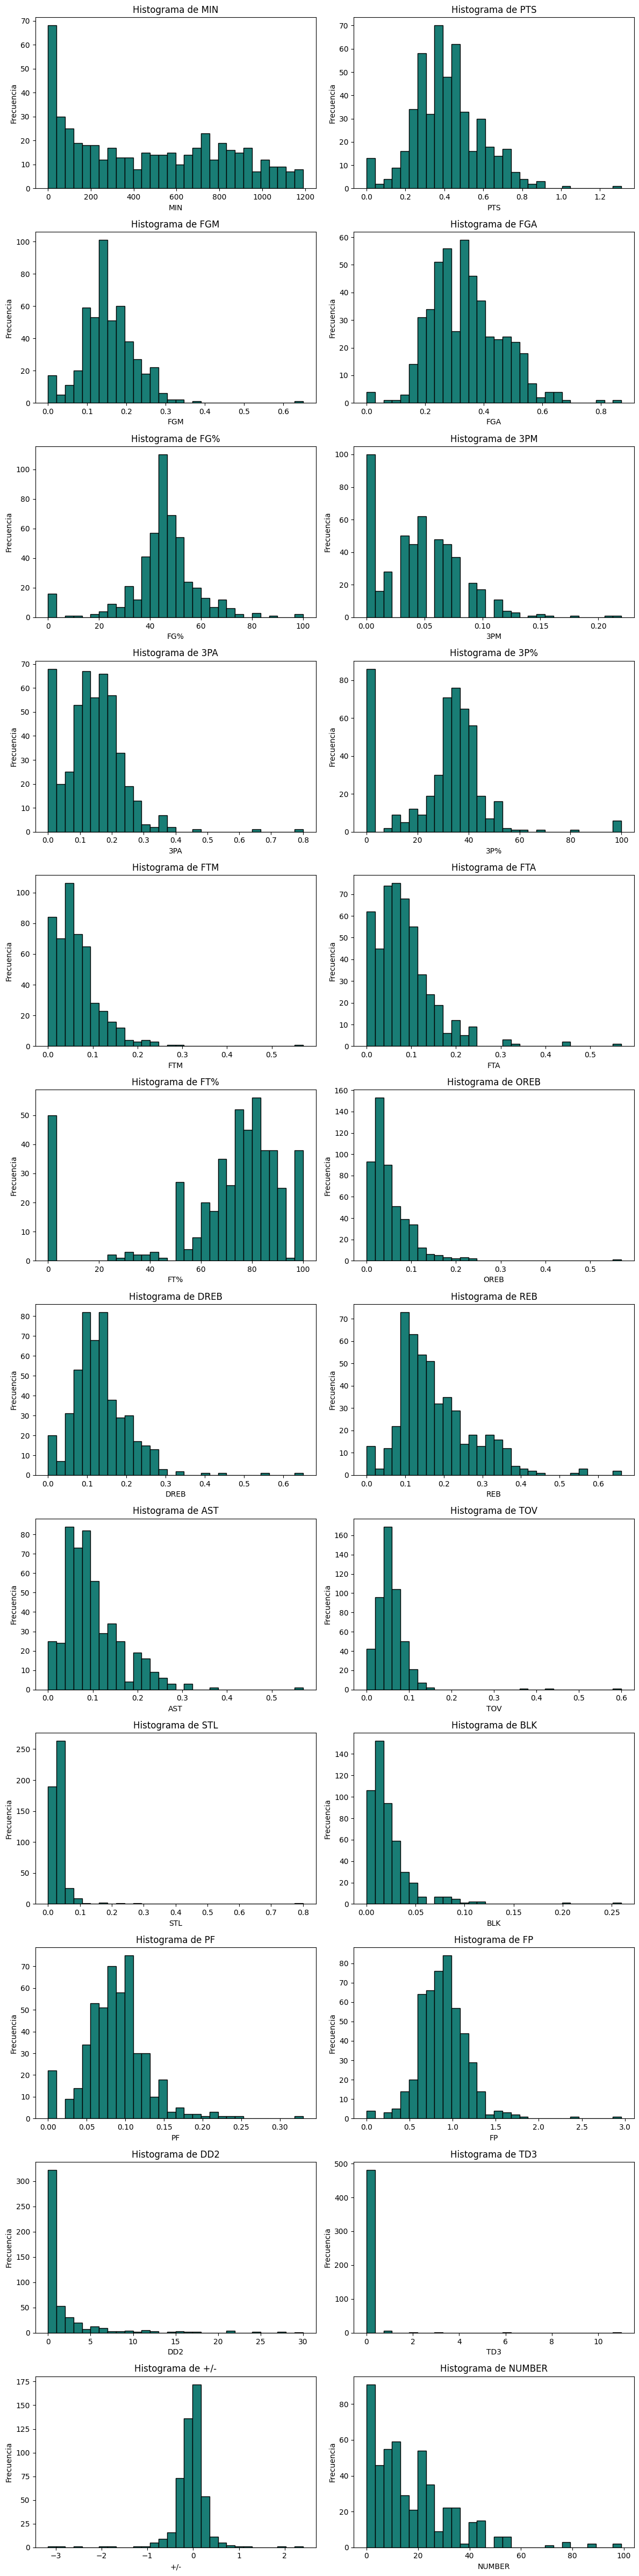

In [5]:
# Filtrar solo las columnas de tipo float
columnas_float = datos_merge.select_dtypes(include=['float64'])

# Definir la disposición de la cuadrícula
num_filas = (len(columnas_float.columns) + 1) // 2
num_columnas = 2

# Crear la cuadrícula de subgráficos
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 4 * num_filas))
fig.subplots_adjust(hspace=0.5)  # Ajustar espacios verticales

# Crear histogramas para cada columna float
for i, columna in enumerate(columnas_float.columns):
    fila = i // num_columnas
    columna_actual = i % num_columnas

    axs[fila, columna_actual].hist(datos_merge[columna], bins=30, edgecolor='black', color='#197D75')
    axs[fila, columna_actual].set_title(f'Histograma de {columna}')
    axs[fila, columna_actual].set_xlabel(columna)
    axs[fila, columna_actual].set_ylabel('Frecuencia')

# Ajustar automáticamente la disposición para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()


### <font color='#197D75'> 2. Clasificacion </font>

Ahora vamos a tomar toda la base de datos inicial, y entrenar nuestro modelo para que sea capaz de interpretar la posicion de cada jugador. Nuevamente, hacemos la salvedad de que si bien conocemos que hoy en dia la NBA cuanta con jugadores que hacen todo, al enfocar nuestros estadisticos en los minutos jugados podemos ver las claras diferencias que existen entre los jugadores de elite con el resto. Si bien el objetivo ahora es poder identificar la posicion del jugador, el foco de analisis no cambia: mientras mas separabilidad tengamos en los datos observados, mayor facilidad para identificar correctamente. Veremos que sucede en este caso:

In [6]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF", "POSITION"]
subset_datos = datos_merge[columnas_interes].copy()
subset_datos.head()

,PTS,DREB,OREB,AST,STL,BLK,FP,PF,POSITION
0,1.31,0.00,0.00,0.00,0.00,0.00,1.31,0.00,C
2,1.02,0.26,0.08,0.18,0.03,0.06,1.86,0.08,C-F
3,0.90,0.20,0.02,0.25,0.04,0.02,1.61,0.05,F-G
4,0.90,0.14,0.02,0.18,0.08,0.02,1.61,0.07,G
5,0.89,0.25,0.08,0.16,0.04,0.03,1.63,0.08,F


Analicemos un poco nuestra variable objetivo. Las posiciones en la NBA son abreviaturas que describen la función principal de un jugador en el campo. Hoy en dia, la versatilidad de los jugadores les permite desempeñar roles que van mas allá de las categorias tradicionales. Las estrategias de juego y las tacticas de los equipos tambien influyen en como se utilizan los jugadores en diferentes posiciones.

<font color='#197D75'> **C (Center):** </font> El centro suele ser el jugador más alto del equipo y juega cerca del aro. Sus responsabilidades incluyen rebotes, bloqueos de tiros y anotaciones de corta distancia. Suelen ser jugadores fisicamente fuertes.

<font color='#197D75'> **C-F (Center-Forward):** </font> Esta posicion combina las características del centro y el ala-pivot. Puede jugar tanto cerca del aro como a distancias intermedias. A menudo, un C-F es versatil y puede realizar diversas funciones.

<font color='#197D75'> **F-C (Forward-Center):** </font> Similar a C-F, esta posición combina características de ala-pívot y centro. Puede jugar tanto en el perímetro como en la pintura.

<font color='#197D75'> **F (Forward):** </font> Los ala-pivots y los aleros son jugadores que suelen jugar en posiciones intermedias entre el perimetro y la pintura. Los ala-pivots pueden ser fuertes y buenos reboteadores, mientras que los aleros suelen ser jugadores versatiles y atleticos.

<font color='#197D75'> **F-G (Forward-Guard):** </font> Esta posicion combina características de alero y escolta. Los jugadores F-G son versatiles y pueden contribuir tanto en el juego perimetral como en situaciones cerca del aro.

<font color='#197D75'> **G-F (Guard-Forward):** </font> Similar a F-G, esta posición combina características de escolta y alero. Estos jugadores son versatiles en sus habilidades y pueden adaptarse a diferentes roles en la cancha.

<font color='#197D75'> **G (Guard):** </font>  Los escoltas (guards) son jugadores cuyas habilidades se centran en el juego perimetral. Pueden ser escoltas armadores (point guards), especializados en facilitar el juego y tomar decisiones tácticas, o escoltas anotadores (shooting guards), que se destacan en la anotación y el tiro exterior.

Veamos, segun nuestro conocimiento, si podemos agrupar POSITION bajo las posiciones clasicas de la NBA:

In [7]:
# Agrupa los datos por la columna 'POSITION'
grupo_por_posicion = subset_datos.groupby('POSITION')

# Calcula las medias para cada grupo
medias_por_posicion = grupo_por_posicion.mean()

# Muestra el resultado
print(medias_por_posicion)

               PTS      DREB      OREB       AST       STL       BLK  \
POSITION                                                               
C         0.429512  0.219756  0.108780  0.072683  0.020488  0.043415   
C-F       0.448500  0.202000  0.092500  0.068500  0.027000  0.052500   
F         0.388038  0.138291  0.048418  0.081519  0.029937  0.021329   
F-C       0.472187  0.188750  0.081250  0.083750  0.025937  0.032500   
F-G       0.448125  0.126875  0.036250  0.100625  0.035000  0.013125   
G         0.430212  0.097513  0.031164  0.126508  0.038730  0.013016   
G-F       0.386316  0.103947  0.030526  0.091053  0.031579  0.010526   

                FP        PF  
POSITION                      
C         1.079268  0.118049  
C-F       1.082500  0.111000  
F         0.841962  0.091962  
F-C       1.038437  0.105625  
F-G       0.894375  0.075000  
G         0.869206  0.075079  
G-F       0.768684  0.082895  


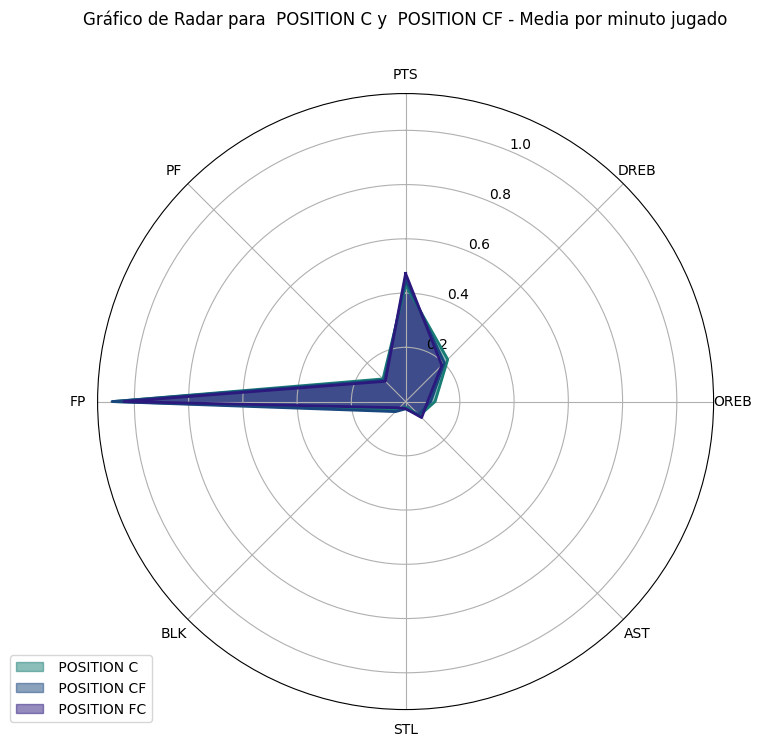

In [8]:
# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Datos para  POSITION C y  POSITION CF
position_C = medias_por_posicion.loc["C", variables_interes].values
position_CF = medias_por_posicion.loc["C-F", variables_interes].values
position_FC = medias_por_posicion.loc["F-C", variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
position_C = np.concatenate((position_C, [position_C[0]]))
position_CF = np.concatenate((position_CF, [position_CF[0]]))
position_FC = np.concatenate((position_FC, [position_FC[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, position_C, color='#197D75', alpha=0.5, label=' POSITION C')
ax.fill(angulos, position_CF, color='#19467D', alpha=0.5, label=' POSITION CF')
ax.fill(angulos, position_FC, color='#2C197D', alpha=0.5, label=' POSITION FC')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, position_C, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, position_CF, color='#19467D', linestyle='solid', linewidth=2)
ax.plot(angulos, position_FC, color='#2C197D', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para  POSITION C y  POSITION CF - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()


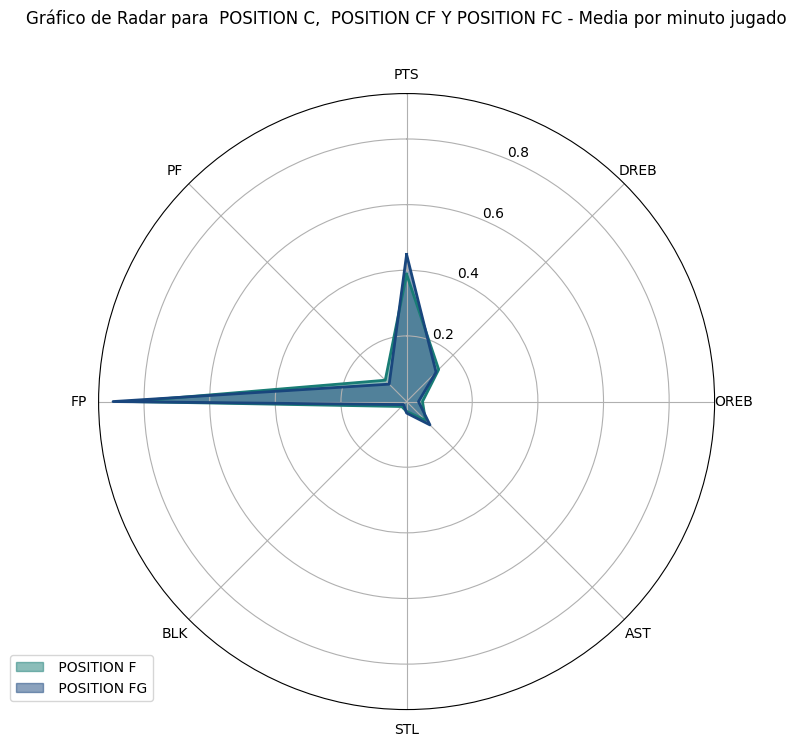

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Datos para  POSITION C y  POSITION CF
position_F = medias_por_posicion.loc["F", variables_interes].values
position_FG = medias_por_posicion.loc["F-G", variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
position_F = np.concatenate((position_F, [position_F[0]]))
position_FG = np.concatenate((position_FG, [position_FG[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, position_F, color='#197D75', alpha=0.5, label=' POSITION F')
ax.fill(angulos, position_FG, color='#19467D', alpha=0.5, label=' POSITION FG')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, position_F, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, position_FG, color='#19467D', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para  POSITION C,  POSITION CF Y POSITION FC - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()


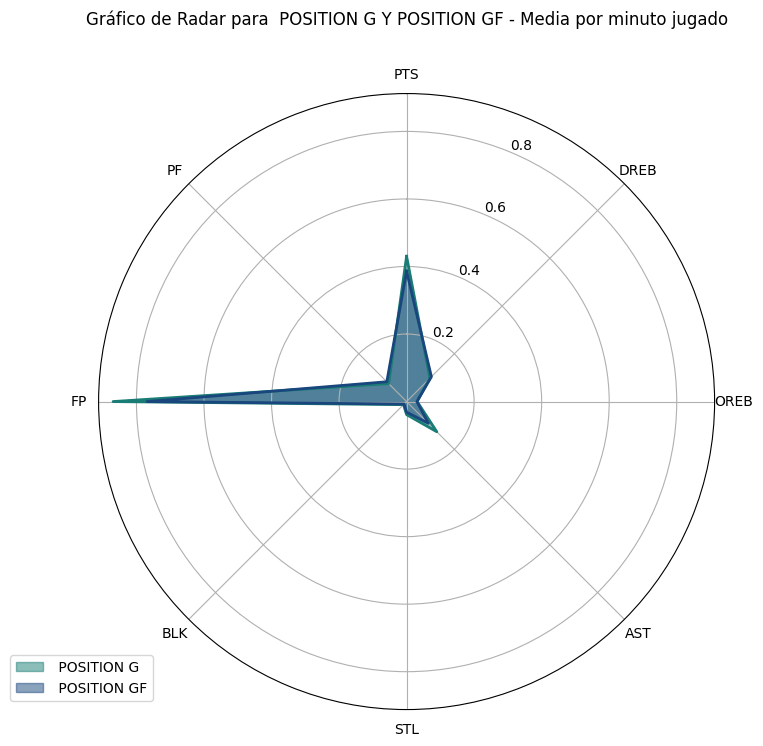

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Datos para  POSITION C y  POSITION CF
position_G = medias_por_posicion.loc["G", variables_interes].values
position_GF = medias_por_posicion.loc["G-F", variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
position_G = np.concatenate((position_G, [position_G[0]]))
position_GF = np.concatenate((position_GF, [position_GF[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, position_G, color='#197D75', alpha=0.5, label=' POSITION G')
ax.fill(angulos, position_GF, color='#19467D', alpha=0.5, label=' POSITION GF')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, position_G, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, position_GF, color='#19467D', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para  POSITION G Y POSITION GF - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()


Estos graficos nos demuestran que, mas alla de que cada jugador juegue en mas de una posicion, las metricas se suelen agrupar en tres partes, con lo cual pasaremos a tener las siguientes agrupaciones: setan considerados como C: C, CF y FC; seran considerados como F: F,FG; y seran considerados como G: G,FG.

In [11]:
def crear_variable(position):
    mapping = {
        "C": "C",
        "C-F": "C",
        "F-C": "C",
        "F": "F",
        "F-G": "F",
        "G": "G",
        "G-F": "G"
    }
    return mapping.get(position, None)

# Aplicar la función para crear la nueva variable
subset_datos["POSICIONES"] = subset_datos["POSITION"].apply(crear_variable)
subset_datos.head()

,PTS,DREB,OREB,AST,STL,BLK,FP,PF,POSITION,POSICIONES
0,1.31,0.00,0.00,0.00,0.00,0.00,1.31,0.00,C,C
2,1.02,0.26,0.08,0.18,0.03,0.06,1.86,0.08,C-F,C
3,0.90,0.20,0.02,0.25,0.04,0.02,1.61,0.05,F-G,F
4,0.90,0.14,0.02,0.18,0.08,0.02,1.61,0.07,G,G
5,0.89,0.25,0.08,0.16,0.04,0.03,1.63,0.08,F,F


In [12]:
#Nos quedamos unicamente con POSICIONES
subset_datos = subset_datos.drop(columns=['POSITION'])

# Agrupa los datos por la columna 'POSITION'
grupo_por_posicion = subset_datos.groupby('POSICIONES')

# Calcula las medias para cada grupo
medias_por_posicion = grupo_por_posicion.mean()

# Muestra el resultado
print(medias_por_posicion)

                 PTS      DREB      OREB       AST       STL       BLK  \
POSICIONES                                                               
C           0.448280  0.205269  0.095806  0.075591  0.023763  0.041613   
F           0.393563  0.137241  0.047299  0.083276  0.030402  0.020575   
G           0.422863  0.098590  0.031057  0.120573  0.037533  0.012599   

                  FP        PF  
POSICIONES                      
C           1.065914  0.112258  
F           0.846782  0.090402  
G           0.852379  0.076388  


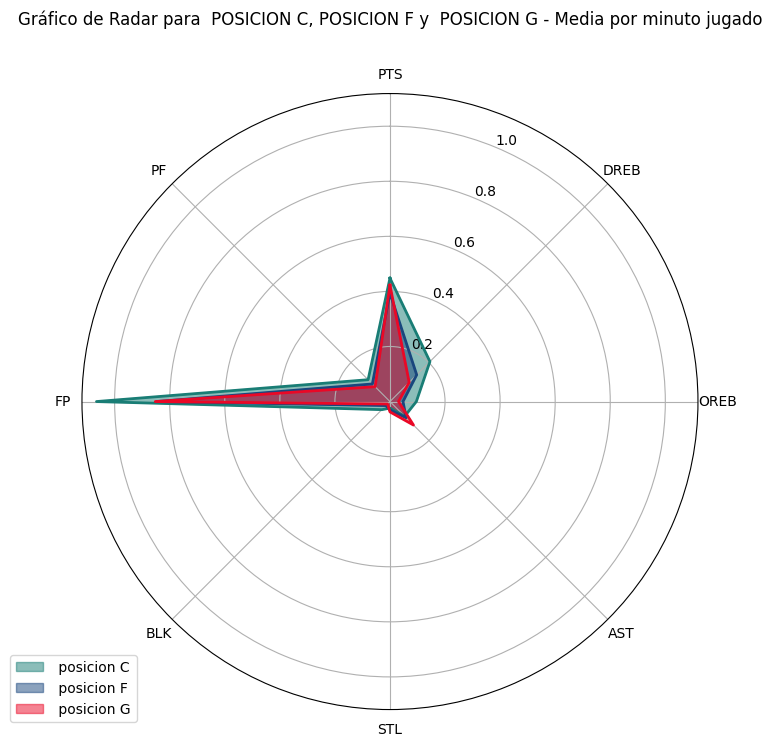

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Datos para  posicion C y  posicion CF
posicion_C = medias_por_posicion.loc["C", variables_interes].values
posicion_F = medias_por_posicion.loc["F", variables_interes].values
posicion_G = medias_por_posicion.loc["G", variables_interes].values

# Número de variables
num_vars = len(variables_interes)

# Ángulos para el gráfico de radar
angulos = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el círculo
posicion_C = np.concatenate((posicion_C, [posicion_C[0]]))
posicion_F = np.concatenate((posicion_F, [posicion_F[0]]))
posicion_G = np.concatenate((posicion_G, [posicion_G[0]]))
angulos += [angulos[0]]

# Configuración del gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angulos, posicion_C, color='#197D75', alpha=0.5, label=' posicion C')
ax.fill(angulos, posicion_F, color='#19467D', alpha=0.5, label=' posicion F')
ax.fill(angulos, posicion_G, color='#EA0826', alpha=0.5, label=' posicion G')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Añadir líneas que conectan los puntos
ax.plot(angulos, posicion_C, color='#197D75', linestyle='solid', linewidth=2)
ax.plot(angulos, posicion_F, color='#19467D', linestyle='solid', linewidth=2)
ax.plot(angulos, posicion_G, color='#EA0826', linestyle='solid', linewidth=2)

# Añadir etiquetas a cada variable
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(variables_interes)

# Ajustar el título del gráfico
ax.set_title('Gráfico de Radar para  POSICION C, POSICION F y  POSICION G - Media por minuto jugado', y=1.1)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar el gráfico
plt.show()


Luego de hacer un analisis de las medias de cada posicion agrupando bajo las posiciones clasicas de la NBA, hemos decidido agrupar las mismas para que queden posiciones mas homogenes, permitiendo esto generar mayor variabilidad entre los grupos definidos. Ahora analicemos un poco como se dan las correlaciones:

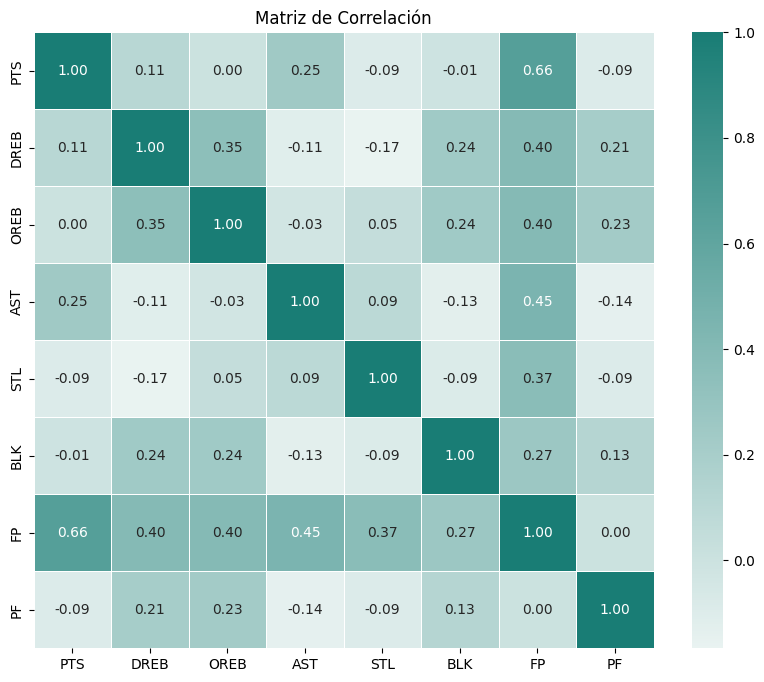

In [14]:
#Nos quedamos unicamente con POSICIONES
correlaciones = subset_datos.drop(columns=['POSICIONES'])

# Calcular la matriz de correlación
correlation_matrix = correlaciones.corr()

# Define tu propio esquema de color verde
green_cmap = sns.light_palette("#197D75", as_cmap=True)

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=green_cmap, fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()


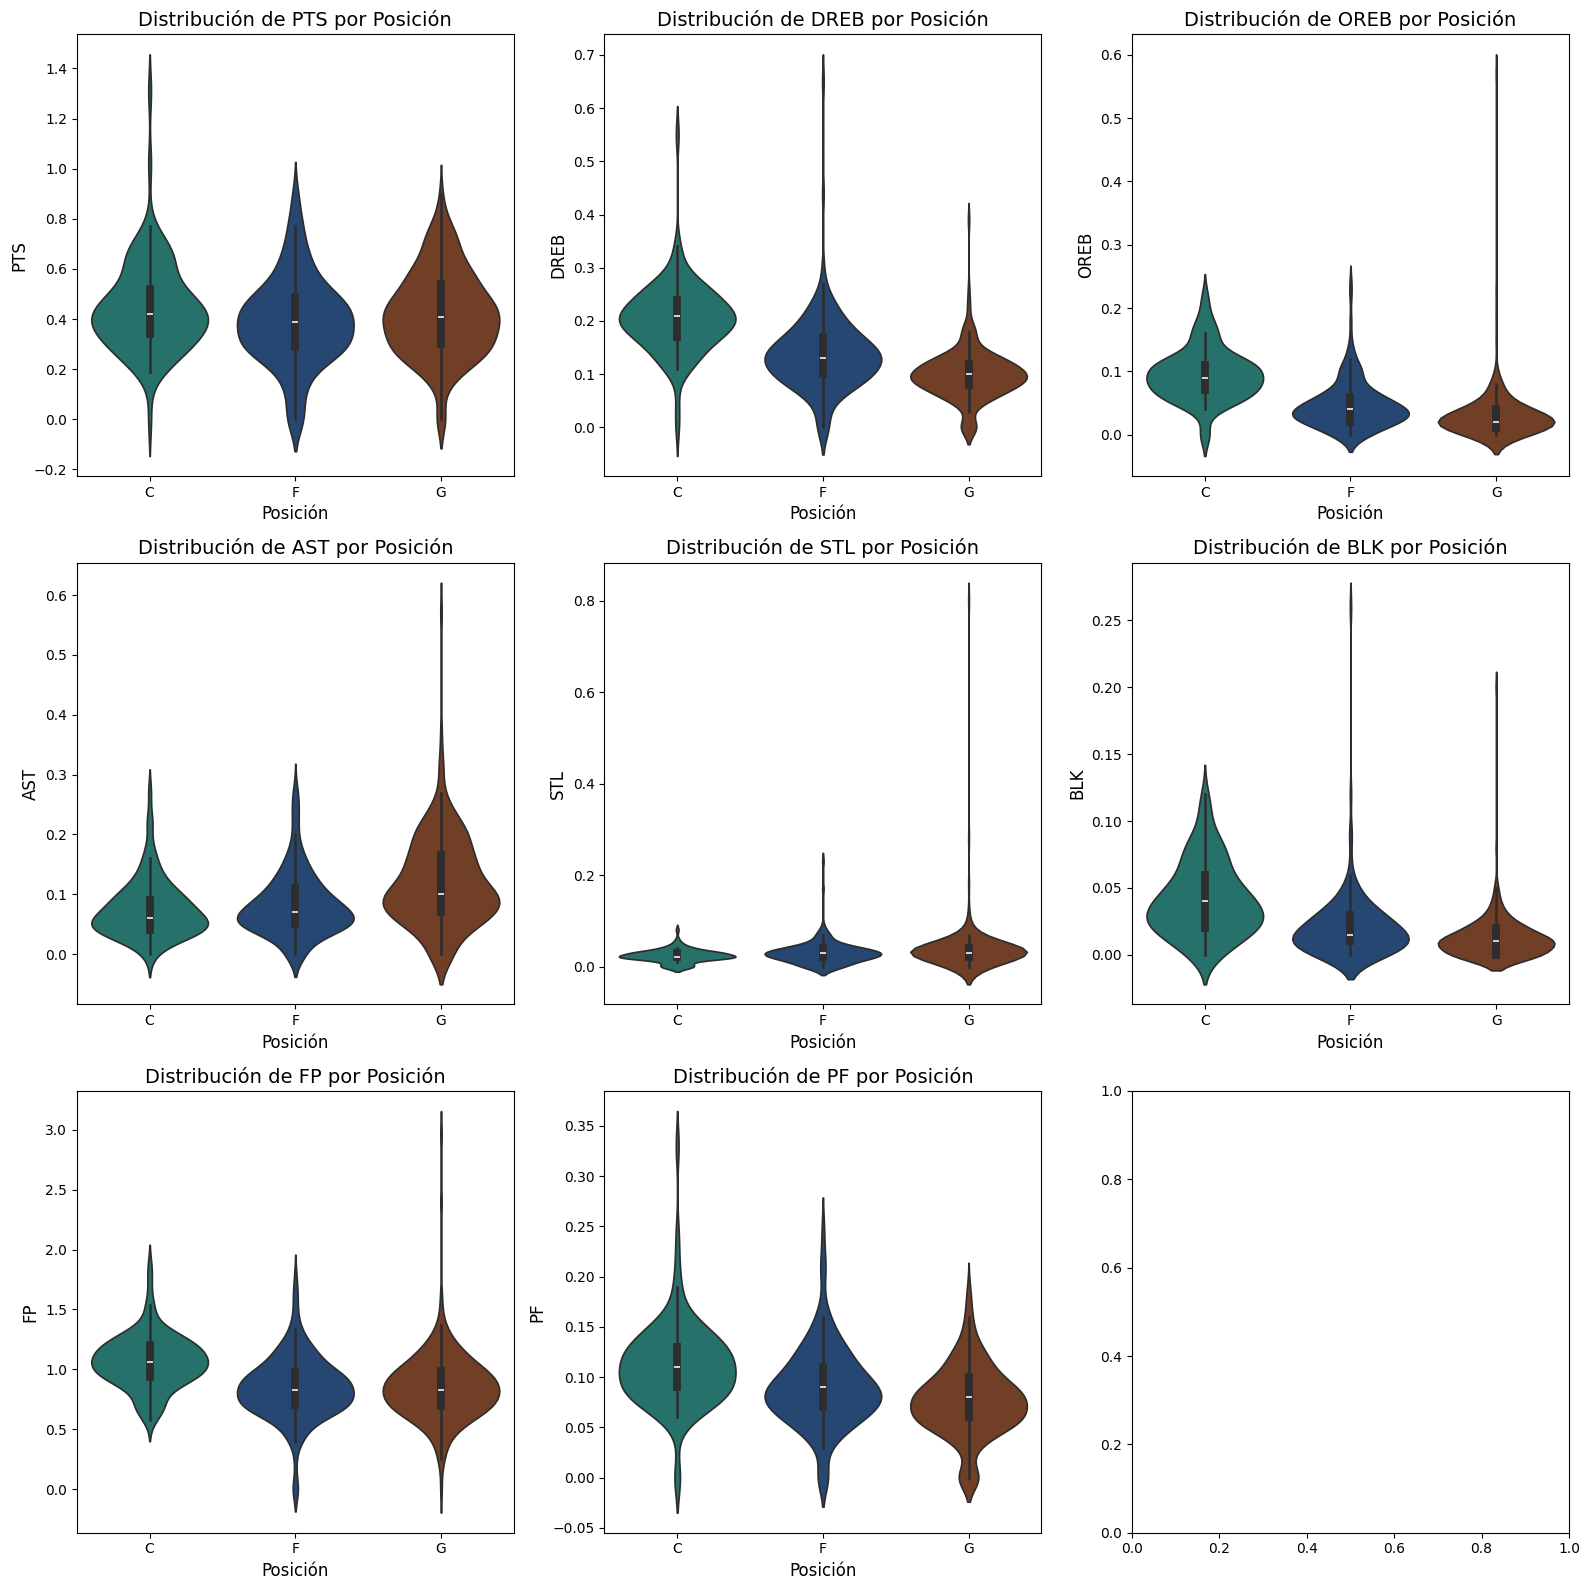

In [15]:
# Crear subplots con 3 filas y 3 columnas (ajusta según sea necesario)
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

# Variables de interés
variables_interes = ["PTS", "DREB", "OREB", "AST", "STL", "BLK", "FP", "PF"]

# Paleta de colores para cada grupo (ajusta según sea necesario)
color_palette = ["#197D75", "#19467D", "#7D3A19"]

# Recorrer las variables de interés y crear gráficos de violín
for i, variable in enumerate(variables_interes):
    fila = i // 3
    columna = i % 3

    # Crear gráfico de violín para la variable actual
    sns.violinplot(ax=axes[fila, columna], x='POSICIONES', y=variable, data=subset_datos, inner='box', width=0.8, palette=color_palette, hue='POSICIONES', legend=False)
    
    # Configurar etiquetas y título
    axes[fila, columna].set_xlabel('Posición', fontsize=12)
    axes[fila, columna].set_ylabel(variable, fontsize=12)
    axes[fila, columna].set_title(f'Distribución de {variable} por Posición', fontsize=14)

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()


Podemos observar que no son homogeneas las distribuciones para cada posicion, lo que puede aproximarnos a cierta variabilidad entre los grupos. Sin embargo, debemos seguir estudiando esto para ver que sucede con nuestros modelos de categorizacion.

In [16]:
# Agrupa los datos por la columna 'POSICIONES' y cuenta el tamaño de cada grupo
observaciones_por_posicion = subset_datos.groupby('POSICIONES').size().reset_index(name='Count')

# Muestra el resultado
print(observaciones_por_posicion)

  POSICIONES  Count
0          C     93
1          F    174
2          G    227


Vemos nuevamente que nuestro modelo no se encuentra perfectamente balanceado. La posicion "C" tiene notablemente menos observaciones que las otras dos. Esto podria causar un problema ya que no solo dificultaria la prediccion de una posicion C, sino que ademas, estaremos ensuciando las estimaciones de las otras posiciones, si no hay una separabilidad en los datos lo suficientemente grande.

### <font color='#197D75'> Modelo 1 - Decision Tree </font>

Ahora si entramos en el nucleo de este ejercicio. Es importante volver a recordar nuestro objetivo: queremos tener un modelo que pueda predecir correctamente la posicion de nuestro jugador. Hemos decidio proceder con las posiciones tradicionales del juego, siendo 3 en general. Es por esta razon que nuestra clasificacion es multiclase, con lo cual, pasaremos a estimar nuestras categorias usando el metodo de KNN realizando iteraciones con tres valores diferentes n=(2;4;6). Para ello, debemos realizar ciertas correcciones previas sobre nuestra base de datos. La primero que haremos es pasar a numerico nuestra variable categorica. Es decir, vamos a cambiar los nombres de las variables de la variable posicion de la siguiente manera: 0 será "C", 1 será "F", 2 será "G". Luego separaremos nuestra base de datos en variables atributos y etiquetas, para poder entrenar a nuestro futuro modelo. Previo a dividir nuestro data set en train y test, vamos a normalizar los datos. Esto se sustenta en la misma justificacion que dimos para el trabajo pasado. Recien ahi podremos realizar la estimacion de nuestro modelo.

In [18]:
columnas_interes = ["PTS", "DREB", "OREB", "AST", "POSICIONES"]
subset_datos2 = subset_datos[columnas_interes].copy()
subset_datos2.head()
X = subset_datos2.iloc[:, :-1]
df_c = subset_datos2

for column in X.columns:
    if subset_datos2[column].dtypes == object:
        df_c[column] =subset_datosdf[column].astype("category").cat.codes

df_c

,PTS,DREB,OREB,AST,POSICIONES
0,1.31,0.00,0.00,0.00,C
2,1.02,0.26,0.08,0.18,C
3,0.90,0.20,0.02,0.25,F
4,0.90,0.14,0.02,0.18,G
5,0.89,0.25,0.08,0.16,F
...,...,...,...,...,...
512,0.00,0.00,0.00,0.00,F
513,0.00,0.00,0.00,0.00,F
515,0.00,0.23,0.00,0.14,G
516,0.00,0.00,0.00,0.00,G


In [19]:
# Separar en atributos (X) y etiquetas (y)
X = df_c.iloc[:, :-1].values
y = df_c.iloc[:, -1].values

X

array([[1.31, 0.  , 0.  , 0.  ],
       [1.02, 0.26, 0.08, 0.18],
       [0.9 , 0.2 , 0.02, 0.25],
       ...,
       [0.  , 0.23, 0.  , 0.14],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.17]])

In [20]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

##### <font color='#197D75'> 2.1 Grid Search </font>

Este metodo de optimizacion consiste en definir un conjunto de valores para cada hiperparametro y evaluar todas las combinaciones posibles de estos valores mediante la validacion cruzada. Este enfoque es simple y garantiza que se explore todo el espacio de búsqueda definido. Sin embargo, al evaluar un numero limitado de combinaciones de hiperparametros, existe el riesgo de que se pierdan configuraciones optimas aumentando la probabilidad del modelo a converger hacia un minimo local en lugar del optimo global.

En la libreria de sklearn podemos ver las configuraciones prestablecidas de cada parametro utilizado para calcular el modelo. Estas son:

class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)

En este apartado de optimizacion intentaremos ajustar algunas variables considerando nuestro data set, intentando ajustar nuestro modelo lo mejor posible contabilizando la restriccion temporal de una ejecucion:

In [21]:
start_time3 = time.time()

model_params={
    'max_leaf_nodes':[50,100,500,5000],
    'min_samples_split':[2,4,6]
}
model = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))

# Calcula el tiempo transcurrido
end_time3 = time.time()
elapsed_time3 = end_time3 - start_time3
print("Tiempo de ejecucion del arbol:", elapsed_time3, "segundos")

Best: 0.602552 using {'max_leaf_nodes': 50, 'min_samples_split': 2}
Tiempo de ejecucion del arbol: 0.14874792098999023 segundos


Ampliemos los parametros a ajustar para ver si logramos aumentar la accuracy:

In [22]:
start_time221 = time.time()
model_params = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
    'splitter': ['best', 'random'],     # Estrategia para seleccionar la división en cada nodo
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2,4,6],     # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],        # Número mínimo de muestras requeridas en cada hoja
    'max_features': ['sqrt', 'log2'],  # Número máximo de características consideradas para dividir un nodo
    'max_leaf_nodes': [50,100,500,5000],  # Número máximo de nodos hoja permitidos
    'min_impurity_decrease': [0.0, 0.1, 0.2],    # Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor
    'ccp_alpha': [0.0, 0.1, 0.2]          # Parámetro de complejidad usado para la poda
}

model = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(model, model_params, cv =3)
model_gs = gscv.fit(X_train, y_train)
print("Best: %f using %s" % (model_gs.best_score_,model_gs.best_params_))
# Calcula el tiempo transcurrido
end_time221= time.time()

elapsed_time221a = (end_time221 - start_time221)
elapsed_time221b = ((end_time221 - start_time221)/1000)/elapsed_time3

print("Tiempo Grid Search:", elapsed_time221a, "segundos")

Best: 0.627901 using {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Tiempo Grid Search: 107.98692226409912 segundos


En este paso hemos mejorado muy poco nuestro accuracy y hemos aumentando en una gran cuantia el tiempo de computo. Claramente, debemos pasar a buscar otro modelo de optimizacion. Veamos que sucede con el Random Search:

##### <font color='#197D75'> 2.2 Random Search </font>

En lugar de probar todas las combinaciones posibles, lo cual puede ser computacionalmente costoso, el Random Search selecciona un conjunto aleatorio de combinaciones de hiperparametros para evaluar. Estas combinaciones se seleccionan de un espacio de busqueda predefinido, que especifica los rangos posibles para cada uno. Por ello, esperamos que este metodo de optimizacion, sea el mas eficientes en terminos computacionales, es decir, suficientemente eficiente en accuracy y tiempo.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Guarda el tiempo de inicio
start_time222 = time.time()

# Excluye la columna 'POSICIONES' del X_train
X_train = subset_datos.drop(columns=['POSICIONES'])
# Incluye la columna 'POSICIONES' en y_class
y_class = subset_datos['POSICIONES']

# Realiza la división entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_class, test_size=0.15, random_state=33)

# Imprime el tamaño de los conjuntos
print("Tamaño dataset entrenamiento:", X_train.shape)
print("Tamaño dataset validación:", X_test.shape)

dt_classifier = DecisionTreeClassifier(random_state=33)

######## Define parameter grid for RandomizedSearch
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 20, 200),
    'min_samples_leaf': np.arange(2, 100)
}

######## Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_dist, n_iter=1000, cv=3, random_state=33)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train, y_train)

######## Make predictions on the test set
y_pred = best_dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

print("Best Parameters:", best_params)

end_time222 = time.time()

# Calcula el tiempo transcurrido
elapsed_time222b = (end_time222 - start_time222) / elapsed_time221a
elapsed_time222a = end_time222 - start_time222

print("Tiempo Random Search:", elapsed_time222a, "segundos")

Tamaño dataset entrenamiento: (419, 8)
Tamaño dataset validación: (75, 8)
Accuracy on the test set: 0.6533
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'gini'}
Tiempo Random Search: 14.2216215133667 segundos


##### <font color='#197D75'> 2.3 Bayes </font>

In [27]:
######## Single package required
from skopt import BayesSearchCV

# Guarda el tiempo de inicio
start_time223 = time.time()

# Excluye la columna 'POSICIONES' del X_train
X_train = subset_datos.drop(columns=['POSICIONES'])
# Incluye la columna 'POSICIONES' en y_class
y_class = subset_datos['POSICIONES']

# Realiza la división entre conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_class, test_size=0.15, random_state=33)

######## Create a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

######## Define parameter search space for Bayesian optimization
param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 20),
    'min_samples_split': np.arange(2, 20, 200),
    'min_samples_leaf': np.arange(2, 100)
}

######## Perform Bayesian optimization with Decision Tree
bayes_search = BayesSearchCV(dt_classifier, param_space, n_iter=50, cv=3, n_jobs=-1)
np.int = int
bayes_search.fit(X_train, y_train)

######## Get the best parameters from Bayesian optimization
best_params = bayes_search.best_params_

######## Train a decision tree with the best parameters
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_classifier.fit(X_train, y_train)

######## Make predictions on the test set
y_pred = best_dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

print("Best Parameters:", best_params)

end_time223 = time.time()

# Calcula el tiempo transcurrido
elapsed_time223a = end_time223 - start_time223
elapsed_time223b = end_time223 - start_time223 / elapsed_time221a

print("Tiempo por optimizacion con bayes:", elapsed_time223a, "segundos")

Accuracy on the test set: 0.6667
Best Parameters: OrderedDict({'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 28, 'min_samples_split': 2})
Tiempo por optimizacion con bayes: 66.32165670394897 segundos


### <font color='#197D75'> Conclusiones </font>

Podemos ver como al optimizar los modelos vamos obteniendo un accuracy mayor, pero sin embargo al mismo tiempo vamos aumentando nuestro tiempo de computo. A pesar de obtener un accuracy relativamente bajo, el arbol de decision optimizado a traves del metodo de Bayes es quien nos otorga un mayor accuracy (66,67%). En segundo lugar tenemos el modelo de random search, que nos otorga un accuracy de 65,33%. Sin embargo, el modelo optimizado por Bayes tarda aproximadamente 66 segundos en ejecutarse, contra 14 segundos del modelo optimizado por random search. Como ya remarcamos anteriormente, nuestro modelo no cuenta con una gran cantidad de observaciones, ni de variables, con lo cual aca podemos elegir quedarnos con el modelo de Bayes como mejor estimador, pero al escalar en cantidad de datos procesados, debemos elegir un modelo mas eficiente en tiempo de ejecucion como el modelo optimizado por random search, ya que hay una deferencia enorme en tiempo de ejecucion y minima en perdida de accuracy. Analicemos con mayor profundidad estas cuestiones:

En este caso hemos optimizado nuestro modelo en un 8% desde la primera vez que lo entrenamos con parametros basicos. Nuestro data set cuenta con 494 observaciones y 8 variables, la diferencia de tiempo entre optimizar entre el metodo de bayes y random search es de aproximadamente 5 veces. Si nuestro modelo basico hubiese tardado en ejecutarse 8 horas en random search, hiperparametrizar el mismo por bayes nos tardaria algo mas de un dia, con lo cual necesitamos conocer estos costos computacionales ya que probablemente el dia de manana trabajemos con data sets mucho mas grandes.

Con lo cual nuestra recomendacion es conocer nuestra base de datos, evaluar cuanto tiempo tenemos para ejecutar el modelo y estimar en base a ese tiempo la cantidad de parametros a optimizar para obtener el mejor modelo posible dentro del tiempo que tengamos para ejecutarlo. La otra opcion es ajustar los parametros en base a nuestro conocimiento del dominio y de la funcionalidad de cada parametro dentro del algoritmo. Dejamos fuera del comentario a la optimizacion via grid search, ya que la misma dio un tiempo mucho mayor, 90 segundos, y un accuracy menor a random search y a bayes.

### <font color='#197D75'> 4. Final </font>

En primer lugar me gustaria agradecer la predisposicion y la buena voluntad que recibi constantemente a lo largo de todo el curso, sin dudas cualquier materia se potencia con la calidad de profesores que han sido a lo largo de estos meses, algo que potencia la cursada en algo aun mas interesante. Lograron ser pacientes para dar a entender infinidad de conceptos nuevos, fueron exigentes con los desafios que imparten a traves de los entregables, y dieron la posibilidad de ampliar mas alla de las consignas, excelente! Sin dudas es una materia que disfrute mucho de haberla cursado, con lo cual, les agradezco. A modo de observacion, quizas hubiera elegido tener alguna entrega antes de las vacaciones de invierno, ya que en enero toma un ritmo muy vertiginoso, y en mi opinion, tener algo mas de tiempo para ver cada practico y poder procesar aciertos y errores en cada uno de ellos potencia el aprendizaje. Espero cruzarlos pronto. Un gran saludo. Mateo. 

pd: les dejo el modelo de regresion logistica que he intentado optimizar, pero que el tiempo no me ha dado para ajustarlo del todo y los resultados tampoco me han acompanado. Me quedara pendiente seguir mejorandolo...

#### <font color='#197D75'> Modelo 2 - Regresion logistica </font>

En este trabajo continuaremos utilizando las bases de datos seleccionadas para la entrega anterior. Como el algoritmo de regresion logistica es especifico para clasificaciones binarias, plantearemos un caso de uso en base a la informacion que tenemos en nuestro data set. El objetivo que tenemos con este tipo de clasificacion es lograr separar en base a la posicion de eleccion del draft si estara en promedio por encima de la media en puntos, rebotes y asistencias. Entendiendo el dominio, haremos 3 regresiones distintas, una para la cantidad de puntos (variable categorica que indica si esta o no por encima de la media), respecto a nuestra variable de posicion de draft. Otra regresion logistica para rebotes, y otra regresion logistica para asistencias. Tambien vamos a plantear el caso en donde estaran las 3 variables juntas respecto a si el jugador esta por encima de la media de las 3 variables. Para ello tendremos que plantear una variable binaria general en donde cada jugador tendra 0 si no esta por encima de las 3 medias, o 1 si esta por encima de las 3 medias. Pasemos a cargar nuestra base de datos y plantear algunas estadisticas para nuestro caso de uso.

https://www.kaggle.com/code/mattop/nba-draft-player-data-analysis-1989-2021/input

In [29]:
#Volvemos a cargar el dataset
datos = pd.read_csv("nbaplayersdraft.csv", sep=';')

In [30]:
datos['PTS_MIN2'] = datos['points'] * datos['points'] / datos['minutes_played']
datos['REB_MIN2'] = datos['total_rebounds'] * datos['total_rebounds'] / datos['minutes_played']
datos['AST_MIN2'] = datos['assists'] * datos['assists'] / datos['minutes_played']
subset6 = datos[['PTS_MIN2', 'REB_MIN2', 'AST_MIN2','points', 'total_rebounds', 'assists', 'minutes_played', 'rank', 'player']]
subset6 = subset6.dropna(subset=['PTS_MIN2', 'REB_MIN2', 'AST_MIN2', 'rank'])
subset6.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

,PTS_MIN2,REB_MIN2,AST_MIN2,points,total_rebounds,assists,minutes_played,rank
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,1618.437144,315.325908,96.545460,3582.559952,1497.907074,774.764988,8404.091127,26.885492
std,2626.796679,548.523912,244.219913,4826.793168,2003.951685,1284.848180,9846.674355,16.073861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
10%,15.649687,4.454185,0.330684,49.700000,28.000000,7.000000,158.400000,6.000000
20%,55.333289,12.517596,1.447949,174.000000,84.000000,28.000000,538.800000,11.000000
30%,124.253662,28.020000,3.902930,401.000000,188.100000,69.000000,1243.200000,16.000000
40%,286.835207,57.173235,8.165582,825.800000,383.800000,146.800000,2321.000000,21.000000
50%,561.734090,103.861343,15.447500,1552.500000,656.500000,258.000000,4222.000000,26.000000
60%,941.429404,171.407230,27.816471,2578.600000,1160.400000,436.200000,7031.600000,31.000000


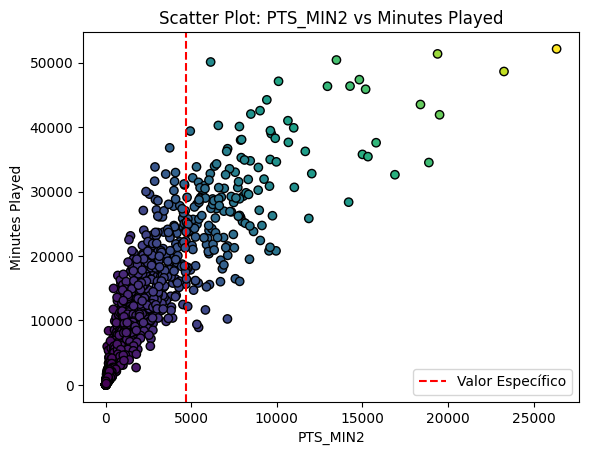

In [31]:
# Crear un scatter plot con colores basados en la variable 'points' y marcando diferencia entre el decimo percentil en PTS_MIN2
plt.scatter(subset6['PTS_MIN2'], subset6['minutes_played'], c=subset6['points'], cmap='viridis', edgecolors='black')
plt.axvline(x=4672.895367, color='red', linestyle='--', label='Valor Específico')
plt.xlabel('PTS_MIN2')
plt.ylabel('Minutes Played')
plt.title('Scatter Plot: PTS_MIN2 vs Minutes Played')
plt.legend()
plt.show()

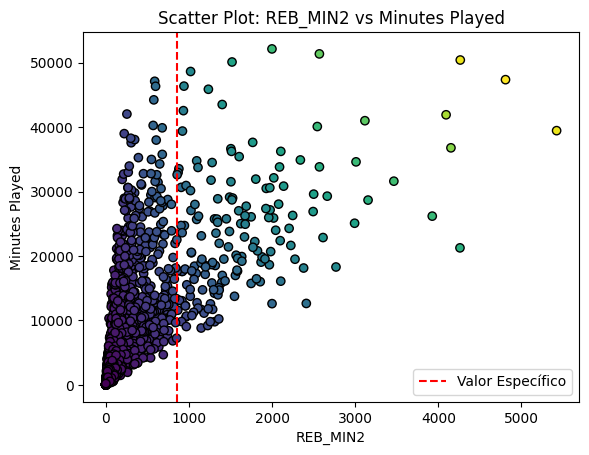

In [32]:
# Crear un scatter plot con colores basados en la variable 'points' y marcando diferencia entre el decimo percentil en PTS_MIN2
plt.scatter(subset6['REB_MIN2'], subset6['minutes_played'], c=subset6['total_rebounds'], cmap='viridis', edgecolors='black')
plt.axvline(x=862.763683, color='red', linestyle='--', label='Valor Específico')
plt.xlabel('REB_MIN2')
plt.ylabel('Minutes Played')
plt.title('Scatter Plot: REB_MIN2 vs Minutes Played')
plt.legend()
plt.show()

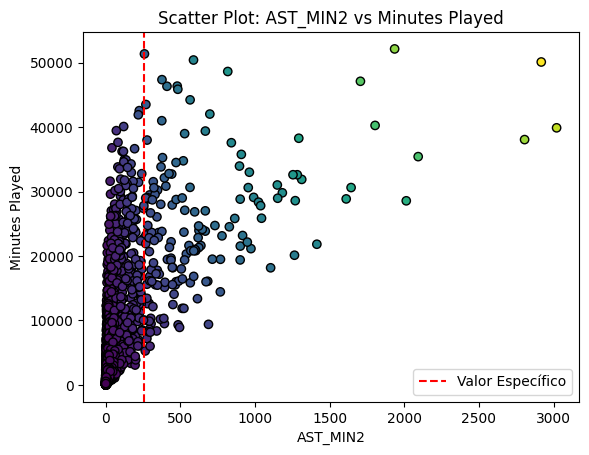

In [33]:
# Crear un scatter plot con colores basados en la variable 'points' y marcando diferencia entre el decimo percentil en PTS_MIN2
plt.scatter(subset6['AST_MIN2'], subset6['minutes_played'], c=subset6['assists'], cmap='viridis', edgecolors='black')
plt.axvline(x=256.859258, color='red', linestyle='--', label='Valor Específico')
plt.xlabel('AST_MIN2')
plt.ylabel('Minutes Played')
plt.title('Scatter Plot: AST_MIN2 vs Minutes Played')
plt.legend()
plt.show()

Ahora si, vemos como nuestro problema tiene una proximidad a nuestra solucion ideal. Vamos a cambiar la estrategia de definicion de nuestro indicador categorico, en vez de tomar las medias, vamos a tomar el ultimo decil para cada variable (PTS_MIN2, REB_MIN2, AST_MIN2), dado que de esta manera estariamos solucionando el problema de aqullos jugadores con pocos minutos de juego. De esta manera, crearemos una variable 3 variables binarias (una para cada caso) en la cual se adjudicara valor 1, si el jugador pertenece al decil con mas puntos por minuto jugado y mas puntos en su carrera (lo mismo para asistencias y rebotes), y 0 en caso contrario.

In [34]:
subset6['Binaria_PTS_MIN2'] = np.where(subset6['PTS_MIN2'] >= 4672.895367, 1, 0)
subset6['Binaria_REB_MIN2'] = np.where(subset6['REB_MIN2'] >= 862.763683, 1, 0)
subset6['Binaria_AST_MIN2'] = np.where(subset6['AST_MIN2'] >= 256.859258, 1, 0)
# Creamos nuestro indicador general
subset6['Indicador'] = np.where(
    (subset6['PTS_MIN2'] >= 4672.895367) | 
    (subset6['REB_MIN2'] >= 862.763683) | 
    (subset6['AST_MIN2'] >= 256.859258), 1, 0
)
subset6.head()

,PTS_MIN2,REB_MIN2,AST_MIN2,points,total_rebounds,assists,minutes_played,rank,player,Binaria_PTS_MIN2,Binaria_REB_MIN2,Binaria_AST_MIN2,Indicador
0,1742.088847,866.807556,41.187009,4494.0,3170.0,691.0,11593.0,1,Pervis Ellison,0,1,0,1
1,2286.478851,358.600342,77.440302,6439.0,2550.0,1185.0,18133.0,2,Danny Ferry,0,0,0,0
2,4537.422904,418.970533,146.870011,10544.0,3204.0,1897.0,24502.0,3,Sean Elliott,0,0,0,0
3,9610.087066,550.114878,125.694126,18336.0,4387.0,2097.0,34985.0,4,Glen Rice,1,0,0,1
4,2099.050098,743.732010,26.566103,5680.0,3381.0,639.0,15370.0,5,J.R. Reid,0,0,0,0


##### <font color='#197D75'> 3.1 Regresion Logistica </font>

In [35]:
# Agrupa los datos por la columna 'POSICIONES' y cuenta el tamaño de cada grupo
observaciones_por_indicador = subset6.groupby('Indicador').size().reset_index(name='Count')

# Muestra el resultado
print(observaciones_por_indicador)

   Indicador  Count
0          0   1326
1          1    342


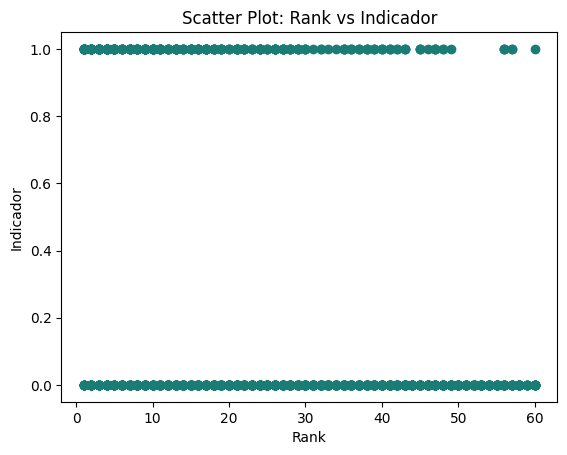

In [36]:
plt.scatter(subset6['rank'], subset6['Indicador'], color='#197D75')
plt.xlabel('Rank')
plt.ylabel('Indicador')
plt.title('Scatter Plot: Rank vs Indicador')
plt.show()

El algoritmo mas sensillo para realizar una clasificacion binaria es la regresion logistica. Para ellos solamente necesimaos una funcion que podamos interpretar 2 estados y que un valor limite nos defina cual es el valor de transicion. Este valor de transicion es el valor limite con el cual se limita nuestra clasificacion final, cualquier valor por debajo pertenecera a la clase 0 y cualquier valor por encima pertenecera a la casle 1. Generalmente encontraremos que este valor de transicion esta ubicado en la media de las observaciones planteadas. Sin embargo, tambien podremos jugar con el mismo modificando su posicion y viendo como nos dan los resultados.

El funcionamiento de la regresion logistica es muy sensillo, se comibinan de forma lineal todas las variables como entrada del algoritmo y a la salida te da un valor entre 0 y 1, al cual lo intepretamos como una probabilidad, que en comparacion al valor de transicion, nos definira si la clasificaremos como grupo 1 o grupo 0. 

El algoritmo de RL tiene varias caracteristicas positivas buscadas por todos los algoritmos de Machine Learning:

1- Interpretabilidad
2- Separabilidad lineal
3- Eficiencia computacional
4- Resultado probabilistico
5- No asume normalidad

En nuestro planteo vemos dos posibles debilidades. La primera de ellas es que a simple vista se nota una separabilidad lineal en el extremo derecho del grafico, en el extremo izquierdo del grafico que es donde estamos buscando que haya una separabilidad clara esto no es tan deterministico, con lo cual puede traer complicaciones a la hora de evaluar sus resultados y funciones de error. La segunda de ellas es que vamos a utilizar una sola variable de entrada que es el puesto en el que ha sido seleccionado el jugador en el ranking, con lo cual, aqui tenemos una ganancia de presicion ya que a menos cantidad de variables mas precisa es la RL.

A modo de aclaracion, en clase hemos visto las funciones de Sigmoid para interpretar la funcion de distribucion de probabilidad de esta variable binaria, en donde iba de menor a mayor de izquierda a derecha. En este planteo encontraremos la funcion inversa, ira de mayor a menor de izquierda a derecha, ya que esperamos que haya mas probabilidad de que los jugadores esten por encima de rendimiento mientras antes hayan sido elegidos en el ranking del draft.

In [37]:
subset7 = subset6[['rank', 'Indicador']]

# Load the Breast Cancer dataset

X = subset7[['rank']]  # Seleccionar solo la columna 'rank'
y = subset7['Indicador']

# Split the dataset into training and testing sets 20% de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Initialize and train the logistic regression model se siembra la semilla para frenar lo aleatorio
model = LogisticRegression(random_state=33)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Accuracy: 0.84

Confusion Matrix:
[[274   4]
 [ 50   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       278
           1       0.60      0.11      0.18        56

    accuracy                           0.84       334
   macro avg       0.72      0.55      0.55       334
weighted avg       0.80      0.84      0.79       334



In [38]:
# Crear DataFrame subset7 con las columnas 'rank' e 'Indicador'
subset7 = subset6[['rank', 'Indicador']]

# Fijar la semilla
np.random.seed(5)

# Dividir los datos en conjuntos de entrenamiento y prueba
subset7_train, subset7_test = train_test_split(subset7, test_size=0.2, random_state=5)

# Obtener las etiquetas 'Indicador' para los conjuntos de entrenamiento y prueba
y_train = subset7_train['Indicador']
y_test = subset7_test['Indicador']

In [40]:
import statsmodels.api as sm

# Crear el modelo de regresión logística con la variable 'Rank'
mrl0 = sm.Logit(subset7_train['Indicador'], sm.add_constant(subset7_train['rank']))

# Ajustar el modelo
result = mrl0.fit()

Optimization terminated successfully.
         Current function value: 0.446360
         Iterations 6


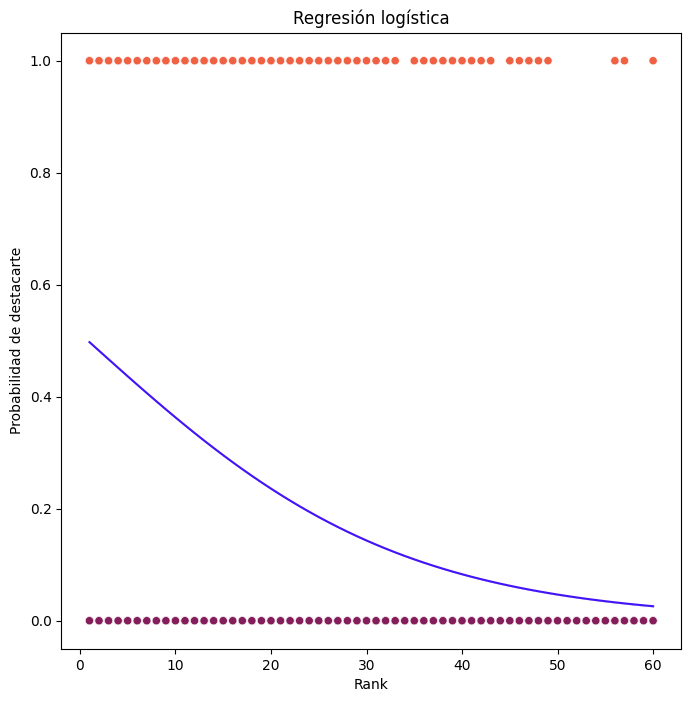

In [41]:
# Función para predecir la probabilidad de destacarse
def predict_probability(model, x):
    return model.predict(sm.add_constant(x), transform=False)

# Crear un gráfico de dispersión y la curva de regresión logística
plt.figure(figsize=(8, 8))
sns.scatterplot(x='rank', y='Indicador', hue='Indicador', marker='o', data=subset7_train, palette='rocket', legend=False)
sns.lineplot(x=subset7_train['rank'], y=predict_probability(result, subset7_train['rank']), color='#4314F7')

# Configurar el gráfico
plt.title('Regresión logística')
plt.xlabel('Rank')
plt.ylabel('Probabilidad de destacarte')
plt.show()


Dado que nuestra base de datos se encuentra desbalanceada en nuestras categorias de indicadores, ajustaremos la regresion logistica en base a class_weight.

##### <font color='#197D75'> 3.1 Random Search </font>

In [43]:
# Definir el espacio de búsqueda para los hiperparámetros
param_distributions = {
    'C': np.logspace(-4, 4, 100),  # Rango de valores para el parámetro C
    'class_weight': [None, 'balanced'],  # Opciones para el balance de clases
    'solver': ['liblinear', 'saga'],  # Métodos de optimización
    'penalty': ['l1', 'l2']  # Tipos de regularización
}

# Crear el modelo de regresión logística
model = LogisticRegression(random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar la búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=1, cv=5, scoring='accuracy', random_state=42)

# Ajustar la búsqueda aleatoria con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener el mejor modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión y otras métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Mostrar los resultados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
print("\nAccuracy: {:.2f}".format(accuracy))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Mejores hiperparámetros encontrados:
{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.0009326033468832199}

Accuracy: 0.79

Confusion Matrix:
[[241  13]
 [ 56  24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       254
           1       0.65      0.30      0.41        80

    accuracy                           0.79       334
   macro avg       0.73      0.62      0.64       334
weighted avg       0.77      0.79      0.76       334



Necesitaremos ajustar mas el modelo ya que no contamos con beneficios a la hora de optimizarlo como si sucedio en los casos anteriores. Mi objetivo a lo largo de los trabajos consistio en tratar de volver cada vez mas consistente el modelo de regresion lineal que intente predecir la probabilidad de destacarse o no destacarse en puntos, rebotes o asistencias en la NBA en base a la posicion del draft en la que hayan sido elegidos. La funcion nos indica que el jugador que es elegido en el puesto numero 1 tiene aproximadamente un 50% de probabilidades de destacarse en alguna de estas metricas. Sin embargo, nuestro accuracy del 84% nos obliga a seguir indagando como poder optimizar el modelo para volverlo mas eficiente.